In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from analiticsLabels import *

DATA = 'data'
V = 'v'
FOV = 'fov'
msg = 'msg'
OBS = 'obstacle'

files = [
    {
        DATA: pd.read_csv('data/3-tree-xvel-10-fov-60.csv'),
        FOV: '60',
        V: '1.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/3-tree-xvel-20-fov-60.csv'),
        FOV: '60',
        V: '2.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/3-tree-xvel-30-fov-60.csv'),
        FOV: '60',
        V: '3.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/3-tree-xvel-10-fov-30.csv'),
        FOV: '30',
        V: '1.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/3-tree-xvel-20-fov-30.csv'),
        FOV: '30',
        V: '2.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/3-tree-xvel-30-fov-30.csv'),
        FOV: '30',
        V: '3.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/0-xvel-10-yvel-00-fov-30.csv'),
        FOV: '30',
        V: '1.0',
        OBS: 'building'
    },
    {
        DATA: pd.read_csv('data/0-xvel-20-yvel-00-fov-30.csv'),
        FOV: '30',
        V: '2.0',
        OBS: 'building'
    },
    {
        DATA: pd.read_csv('data/0-xvel-30-yvel-00-fov-30.csv'),
        FOV: '30',
        V: '3.0',
        OBS: 'building'
    },
    {
        DATA: pd.read_csv('data/0-xvel-10-yvel-00-fov-60.csv'),
        FOV: '60',
        V: '1.0',
        OBS: 'building'
    },
    {
        DATA: pd.read_csv('data/0-xvel-20-yvel-00-fov-60.csv'),
        FOV: '60',
        V: '2.0',
        OBS: 'building'
    },
    {
        DATA: pd.read_csv('data/0-xvel-30-yvel-00-fov-60.csv'),
        FOV: '60',
        V: '3.0',
        OBS: 'building'
    },
]

## Online

In [5]:
import sys
sys.path.append('../')
from obstacleFinder import ActivationDecisionMaker

In [6]:

def run_experiments(save=False, mean=False):
    for f in files:
        vel = float(f[V])
        dm = ActivationDecisionMaker(vel=vel, report=True)
        save_name = 'activation-alg-obstacle-' + f[OBS] + '-vel-' + f[V].replace('.', '') + '-fov-' + f[FOV] + '.pdf'
        msg = 'Approaching ' + f[OBS] +'. v=' + f[V] + ', FOV=' + f[FOV] + '.'

        activations = f[DATA][ACTIVATION]
        decisions = []


        for i, act in enumerate(activations):
            decision = dm.step(act, distance=f[DATA][POSITION][i])
            #print(decision)

        dist = -1 * np.array(dm.report_distance)

        plt.figure()
        plt.xlabel('Distance')
        plt.ylabel('Activation')
        plt.title(msg)
        plt.plot(dist, dm.report_activations, label='activation')
        plt.plot(dist, dm.report_decisions, label='stop decision')
        plt.plot(dist, dm.report_thresholds,'--', color='#5A5A5A', label='threshold')
        if mean:
            plt.plot(dist, dm.report_mean,'--', color='#A1A1A1', label='mean')
        plt.legend()
        
        if save:
            plt.savefig('figs/' + save_name)


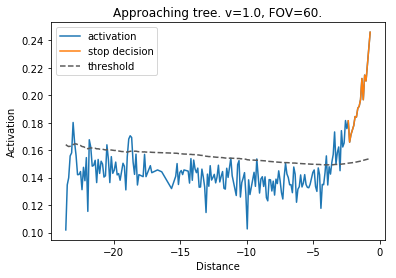

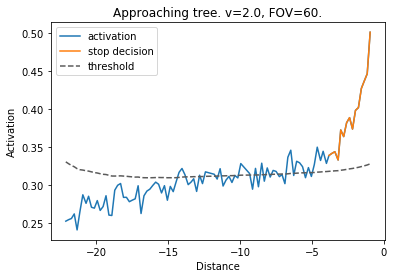

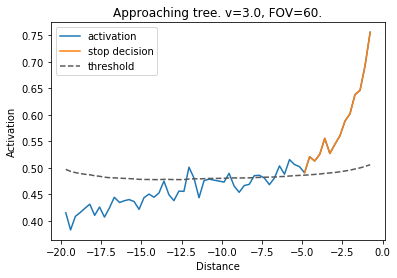

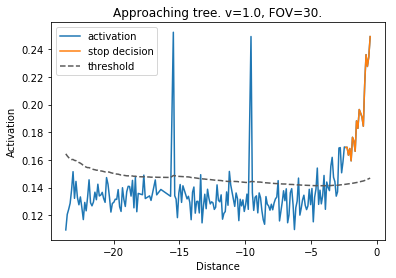

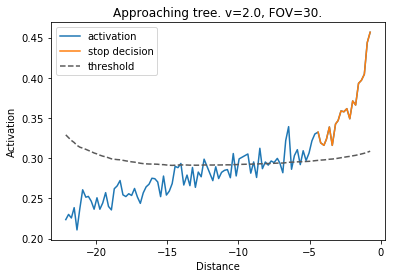

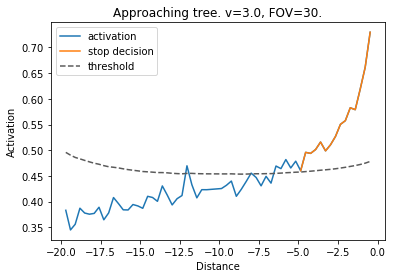

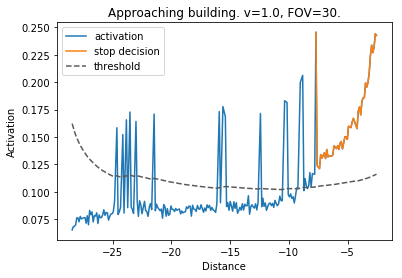

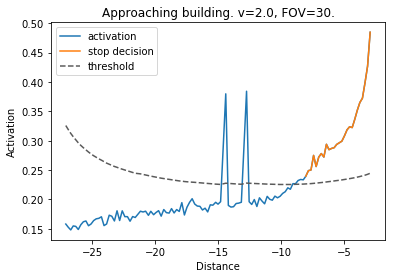

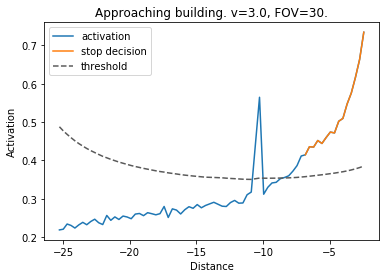

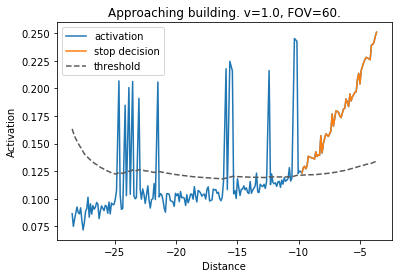

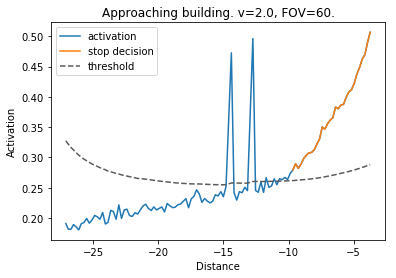

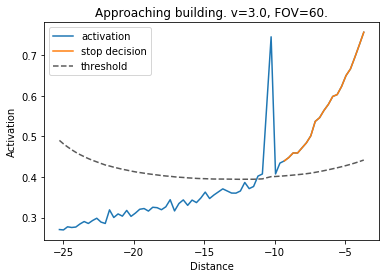

In [7]:
run_experiments(save=True)

## Offline

In [8]:
def no_outlier(data, m=1):
    data = np.array(data)
    mean = np.mean(data)
    standard_deviation = np.std(data)
    distance_from_mean = abs(data - mean)
    not_outlier = distance_from_mean < m * standard_deviation
    return data[not_outlier]


stop = lambda i, N, arr: i < len(arr) - (N - 1)


def filter_activations(activations):
    # Filter activations to remove outliers
    filt_act = no_outlier(activations)
    # Also when the gradient is negative
    filt_act = filt_act[np.gradient(filt_act) > 0]
    threshold = (np.mean(filt_act) + 
                 0.4 * np.std(filt_act))
    return filt_act, threshold
    

def check_threshold(arr, threshold):
    return arr > threshold
    

def make_decision(activations, threshold, minimum):
    split = int(minimum / 2)
    num = len(activations)
    stays_p = check_threshold(activations, threshold)
    return [False] * (split + 1) + [np.all(stays_p[i - split : i + split])
            for i in range(num) if i > split]
    
    

def test_activations(df, N=5, grad_width=5, fov='60', v='2', plot=False):
    # Sort by position
    df.sort_values(POSITION)
    activations, threshold = filter_activations(df[ACTIVATION])
    
    decision = make_decision(activations, threshold, 4)
    s = decision * activations
    s[s == 0] = np.nan
    if plot:
        # Create two subplots and unpack the output array immediately
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        f.suptitle('Activations for v=' + v + ' and FOV=' + fov)
        ax1.plot(-df[POSITION], df[ACTIVATION], color='green', label='Original activation')
        ax1.set_title('Original activation')
        ax1.set_ylim(bottom=-0.1)
        pos = np.linspace(np.max(df[POSITION]), np.min(df[POSITION]), len(activations))
        ax2.set_title('Processed activation')
        ax2.plot(-pos, activations, label='Processec activation')
        ax2.plot(-pos, [threshold] * len(activations), '--', color='gray', label='Threshold')
        ax2.plot(-pos, s, label='Classified as obstacle')
        ax2.set_xlabel('Distance (m)')
        f.tight_layout(rect=[0, 0.03, 1, 0.95])
        f.savefig('figs/processed-activation-v-' + v + '-fov-' + fov + '.pdf')
    
    std_act = activations[:-len(s[~np.isnan(s)])]
    return np.mean(std_act), np.std(std_act)

### Machine learning

[0.1329795]
[0.09050949]


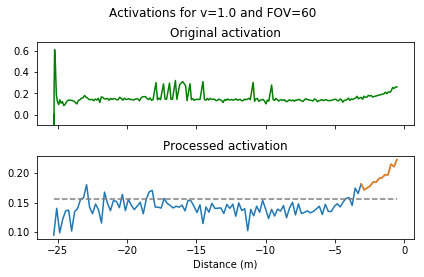

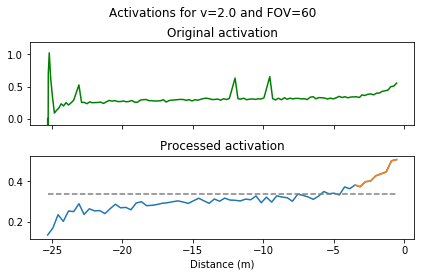

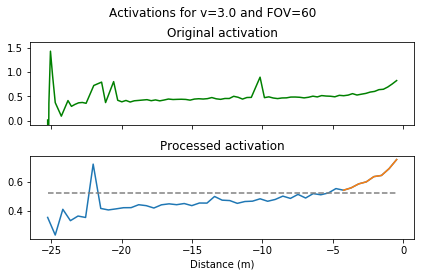

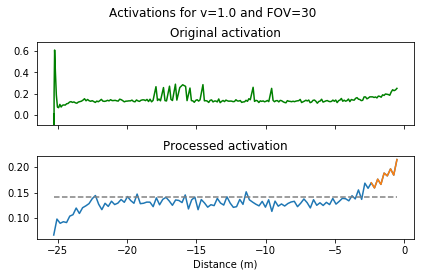

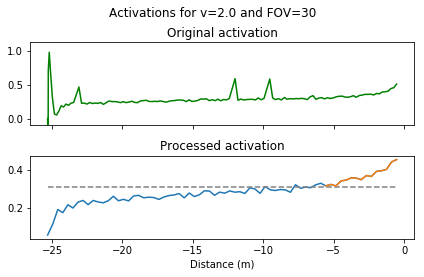

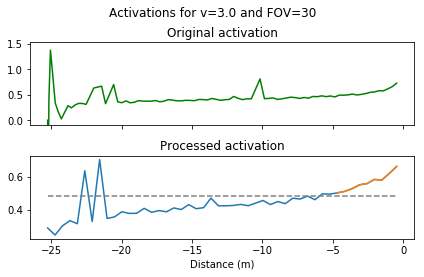

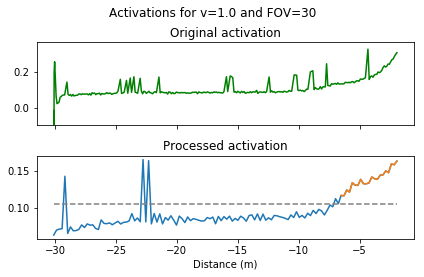

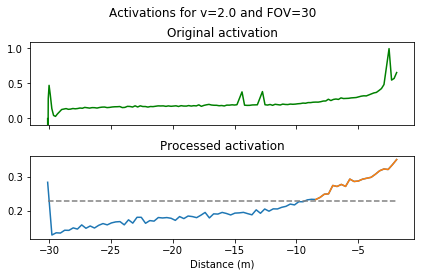

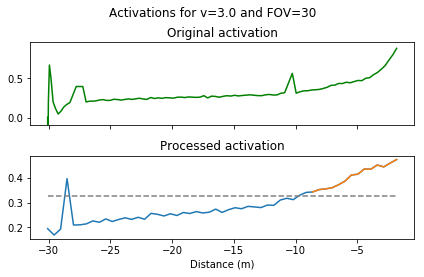

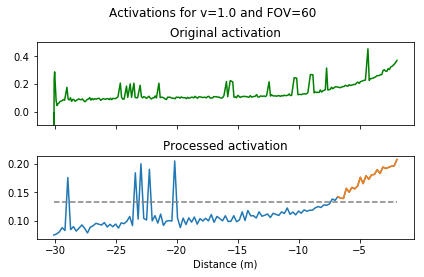

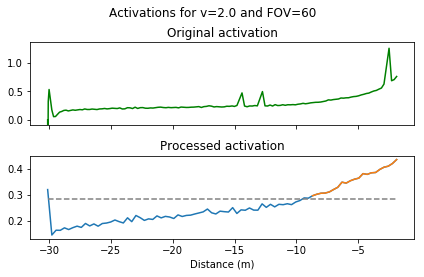

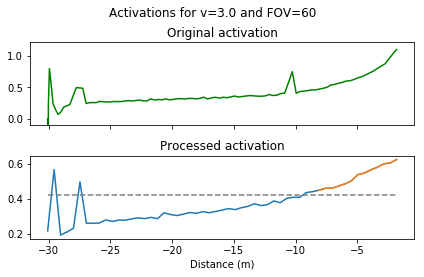

In [9]:
noise_means, noise_stds = [], []
means = []
stds = []
vels = []


for f in files:
    mean, std = test_activations(f[DATA], fov=f[FOV], v=f[V], plot=True)
    vel = float(f[V])
    if vel < 4:
        
        noise_act = f[DATA][ACTIVATION]
        noise_means.append(np.mean(noise_act))
        noise_stds.append(np.std(noise_act))
        
        
        vels.append(vel)
        means.append(mean)
        stds.append(std)
        


        
w_means = np.linalg.lstsq(np.array([vels,]).T, means, rcond=None)[0]
w_stds = np.linalg.lstsq(np.array([vels,]).T, stds, rcond=None)[0]


w_noise_means = np.linalg.lstsq(np.array([vels,]).T, noise_means, rcond=None)[0]
w_noise_stds = np.linalg.lstsq(np.array([vels,]).T, noise_stds, rcond=None)[0]


print(w_noise_means)
print(w_noise_stds)